# Notebook for meaning and variation

Turku/Åbo 2017

This notebook is for investigating texts from the collection of digitized text at the Norwegian National Library: http://www.nb.no. Access is via an API which resides at http://api.nb.no/ngram, which the code provides an interface to. Some of texts (books) can be freely downloaded from https://www.nb.no/sprakbanken/show?serial=oai%3Anb.no%3Asbr-34&lang=en. 

There is code for fetching references to books via URNs, plotting trendlines for words, and getting concordances.

One way of comparing texts is to look at frequencies of a selected number of words. For this purpose heatmaps are used, which performs a kind of visual relativization of data. 



In [1]:
# Boilerplate imports

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import json
import requests
from IPython.display import HTML
import seaborn as sns
from scipy.spatial.distance import cosine

sns.set_style('white')
%matplotlib inline

 ## Program code (activate and scroll past it ...)
 
 The functions defined below provide an interface, and serve as an example of how to use the API.

In [2]:

def get_ngrams(words, params={}, delta='og'):
    import requests
    import pandas as pd
    
    result = dict()
    found_word = False
    for word in words + [delta]:
        params['word'] = word
        r = requests.get("https://api.nb.no/ngram/ngram", params)   
        if r.status_code==200:
            result[word] = r.json()
            found_word=True

    if found_word==True:
        temp = pd.DataFrame(result)
        if delta != "":
            res = temp[words].divide(temp[delta], axis=0)
        else:
            res = temp
    else:
        res = r
    return res

def get_ngram(word, params=dict()):
    import requests
    import pandas as pd
    
    para = params
    para['word']= word
    r = requests.get('https://api.nb.no/ngram/ngram', params=para)
    r = pd.DataFrame.from_dict(r.json(), orient='index').sort_index()
    #r.columns = [word]
    return r


def heatmap(df, color='red'):
    return df.fillna(0).style.background_gradient(cmap=sns.light_palette(color, as_cmap=True))

def get_freq(words, params=dict()):
    import requests
    import pandas as pd
    
    para = params
    para['words']= words
    r = requests.post('https://api.nb.no/ngram/freq', json = para)
    #r.columns = [word]
    return r.json()

def get_urns(params=dict()):
    import requests
    
    para = params
    r = requests.get('https://api.nb.no/ngram/urn', json = para)
    #r.columns = [word]
    return r.json()

def get_urnfreq(urn, top=10, cutoff=10):
    params = dict()
    params['urn'] = urn
    params['top'] = top
    params['cutoff'] = cutoff
    r = requests.get('https://api.nb.no/ngram/urnfreq', json = params)
    return r.json()
    

def get_konk(word, url='konk',  params=dict(), html=True):
    import requests
    import pandas as pd
    
    para = params
    para['word']= word
    r = requests.get('https://api.nb.no/ngram/{url}'.format(url=url), params=para)
    if html:
        rows = ""
        for x in r.json():
            rows += """<tr>
            <td>
                <a href='{urn}' target='_'>{urnredux}</a>
                <td>{b}</td>
                <td>{w}</td>
                <td style='text-align:left'>{a}</td>
                </tr>\n""".format(urn=x['urn'], 
                                  urnredux=','.join([x['author'], x['title'], str(x['year'])]),
                                  b=x['before'],
                                  w=x['word'],
                                  a=x['after']
                                 )
        res = "<table>{rows}</table>".format(rows=rows)   
    else:
        try:
            res = pd.DataFrame(r.json())
            res = res[['urn','author','title','year','before','word','after']]
        except:
            res= pd.DataFrame()
        #r = r.style.set_properties(subset=['after'],**{'text-align':'left'})
    return res    
    
def plotrelative(ng1, ng2, period=(1850, 2005), window=2, figsize=(15,8), legend=False, title='Relative trend', ymin = 0):
    import matplotlib.pyplot as plt
    
    (ng1/ng2).loc[str(period[0]):str(period[1])].rolling(window, win_type='triang').mean().plot(legend=legend, title=title, figsize=figsize);
    fymin, fymax = plt.ylim()
    plt.ylim(ymin, fymax)
    return


def get_urnkonk(word, params=dict(), html=True):
    import requests
    import pandas as pd
    
    para = params
    para['word']= word
    r = requests.post('https://api.nb.no/ngram/urnkonk', json = para)
    if html:
        rows = ""
        for x in r.json():
            rows += """<tr>
                <td>
                    <a href='{urn}' target='_blank' style='text-decoration:none'>{urnredux}</a>
                </td>
                <td>{b}</td>
                <td>{w}</td>
                <td style='text-align:left'>{a}</td>
            </tr>\n""".format(urn=x['urn'],
                              urnredux="{t}, {f}, {y}".format(t=x['title'], f=x['author'], y=x['year']),
                              b=x['before'],
                              w=x['word'],
                              a=x['after']
                             )
        res = """<table>{rows}</table>""".format(rows=rows)    
    else:
        res = pd.DataFrame(r.json())
        res = res[['urn','before','word','after']]
        #r = r.style.set_properties(subset=['after'],**{'text-align':'left'})
    return res

def trend_plot(df,yf='1880',yt='2000', window=3, legend=False, title='Trend'):
    df.loc[yf:yt].rolling(window=window).mean().plot(figsize=(15,8),legend=legend, title=title)
    return
    
def periods(p_start, p_end, step):
    årstall = list(range(p_start, p_end, step))
    ypairs = []
    for i in range(len(årstall) - 1):
        ypairs.append((årstall[i], årstall[i+1]))
    return ypairs
    
def barplot(df):
    df.fillna(0).plot(kind='bar',figsize=(15,8), color= sns.hls_palette(len(df), l=.4, s=.9));
    return 

def dewey_dist(word):
    res = dict()
    for i in range(10):
        dta = get_ngram(word, params={'corpus':'bok','ddk':i}).sum()
        res[str(i*100)] = dta
    return res

def js_delta(js1, js2):
    # Arguments as json, output a dataframe
    return pd.DataFrame.from_dict(js1, orient='index')/pd.DataFrame.from_dict(js2, orient='index')

def get_words_from_urnset(words, urnset):
    urns = dict()
    for urn in urnset:
        urns[urn] = dict(get_freq(words, {'urn':urn}))
    return urns


## Concordances

Investigate a word with the function *get_konk*. It returns a concordance of the key word along with a link to metadata and the full text. If you live outside Norway, go to https://www.nb.no/samlingen/bokhylla-utlandet and apply for a permission to read texts published up to the year 2000.

In [20]:
HTML(
get_konk('onani',params={'corpus':'bok', 'title':'%','author': '%%', 'before':18,'after':18, 'size':2, 'offset':0})
)

"Waal, Helge,Nic Waal,1991 Evangs artikler om",onani,"og seksuallivets teknikk , ble dette blant de aller mest leste artikler i et blad som folket kastet"
"Zetterholm, Tore,Stenene rope,1991 livets tilbehør og fremfor alt de seksuelle . Å avbilde en carcancha i ferd med et samleie eller",onani,med en jordisk kvinne var å gi magisk hjelp til den døde .
"Malm, O.,Barneformindskelsen i Norge og dens aarsaker,1916 samleie bare for at tilfredsstille kjødslysten . Samleie uten forplantningshensigt betegnes derfor av den katolske moralteologi som ægteskabelig",onani,"og hører til de syv dødssynder , fordi handlingen er mod naturens orden . Dette har været lære"
"Ruge, Herman,Tanker omkring skolen,1954 seksualproblemene på kroppen . Mange av de unge bærer på en skjult skyldfølelse for urene tanker eller åpenbar",onani,". Det kan sikkert være lett for en religionslærer , om li2n vil , å holde denne skyldfølelse"
"Eikenes, Randi,Ny hverdag,1991 Seksuelle behov kan uttrykkes og tilfredsstilles på flere måter : Samleie ,",onani,"og med fysisk kontakt uten spesielle seksuelle handlinger . Nå er ikke seksualitet bare fysisk uttrykk , men"
"Eikenes, Randi,Ny hverdag,1991 han / hun ha det som nå ? Har vedkommende rett til å få opplæring / trening i",onani,? Begrunn svarene dine .
"Winge, Paul,norske sindssygeret,1917 desuden hindre ham i at skade sig selv ved selvmordsforsøg , selvmutilation eller ved den dengang 522 frygtede",onani,". Endelig kom hertil den sidste — og vel ikke min63t væsentlige — indikation , den disciplinære ,"
"Liabøe, Johs.,Religionshistorie,1913 Men Onan begik den synd som elter ham har faaet navn",onani,. Og det var ondt i Herrens øine og han tog o ^ Baa ham ak dage .
"Dokk, Trygve,Religiøs etisk uppseding,1929 ein viktig lekk i moral-upplæringa. Etter ei grundig ut ^ reidin ^ um B ^ lvßulkin ^ (",onani,") , 3 kriv Leeli ( Veiledning til at opdrage 0.5 . b . , s . 107"
"Brynildsen, J.,Norsk-engelsk ordbog,1917 , introspection of oneself ; besmittelse s . | abuse , - defilement , - pollution . Se",onani,"! beftnltct s.jappointed , - conslituted ; - bestemmelse s.-determination ; = § = ret a right to"
",Kristen livsholdning i dag,1945 berre skje i ekteskap, llet kan like godt skje ved krie sekBualB2mband , i kameratekteBkap, ved masturbasjon (",onani,) eller ved perverBe utBlag av kjonnsdrikta . Det gjeld berre a koma burt kra det gamaldagse synet


## Trendplots

Any word can be plotted and compared, the function *get_ngram* extracts total frequencies from texts. For a simpler interface, one may also go to the web service https://www.nb.no/sp_tjenester/beta/ngram_1/#ngram/query?terms=trend&lang=all&case_sens=0&freq=rel&corpus=bok


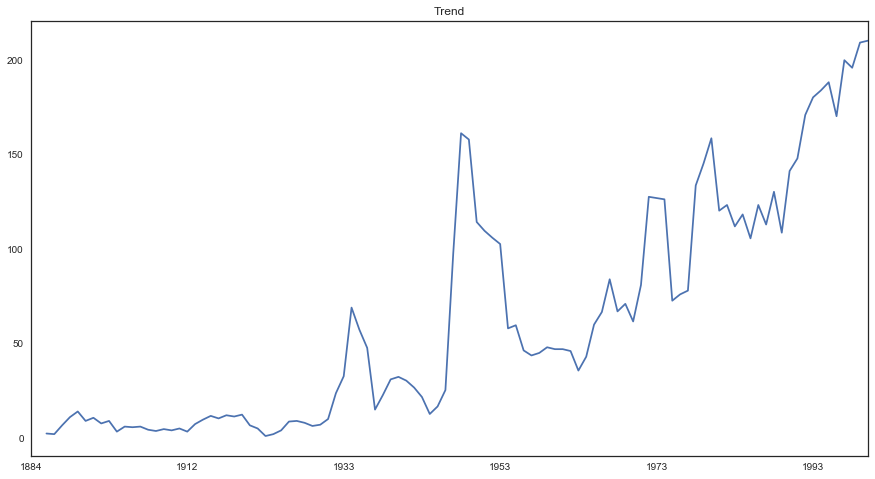

In [21]:
arbeid_ng = get_ngram('onani', {'corpus':'bok'})
trend_plot(arbeid_ng)


## Relativization 

In order to plot relative trends, one need to divide the total frequency with som other number that varies over year, like the frequency of all words. Here we use the relative frequency of one trend over another, and choose hi frequency words like coordination and punctuation

In [22]:
coord_ng = get_ngram('og',{'corpus':'bok'})
punct_ng = get_ngram('.', {'corpus': 'bok'})

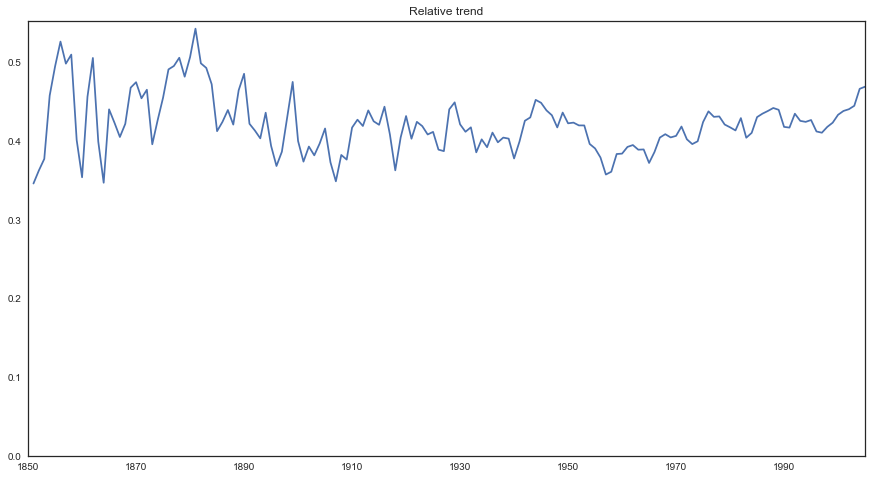

In [27]:
plotrelative(coord_ng,punct_ng)
plt.savefig('turku.png', dpi=300)

## Relative plot

The first trend line can be relativized using *coord_ng* and *punct_ng*

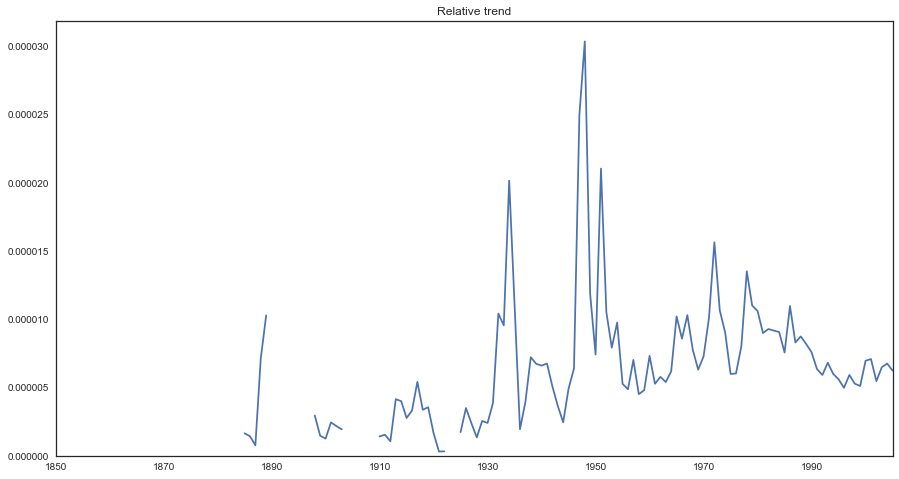

In [23]:
plotrelative(arbeid_ng, coord_ng + punct_ng)

## Examine identity

Identity is modelled in terms of what expressed in letters going from immigrants. For this purpose we try out an approach where a particular selection of words, words that are believed to connect to identity dimensions like family, work, health among others, and are compared with other texts. 

### URNs for the texts

In order to specify a particular corpus the function *get_urns* is used. It finds books based on title, author or year, and suggests a couple of reduced URN-identifiers.

In [52]:
# The letters 
a_urns = get_urns({'title':'%amerika til%'})
amerika_urns = [x[0] for x in a_urns]
a_urns

[[2007091801006, '', 'Fra Amerika til Norge', 1992],
 [2007112704027, '', 'Fra Amerika til Norge', 1993],
 [2009042900008, '', 'Fra Amerika til Norge', 2002],
 [2010051906100, '', 'Fra Amerika til Norge', 1992],
 [2015062208208, '', 'Fra Amerika til Norge', 2010],
 [2015070908050, '', 'Fra Amerika til Norge', 2009],
 [2015070908064, '', 'Fra Amerika til Norge', 2011]]

In [53]:
# The letters 
a_urns2 = get_urns({'title':'%amerika%'})
amerika_urns2 = [x[0] for x in a_urns2]
a_urns2

[[2006082100008,
  'Storm, Gustav',
  'Christofer Columbus og Amerikas opdagelse',
  1893],
 [2014072206080, 'Wiger, Merete', 'Min amerikanske kusine', 1984],
 [2006111401050,
  'Jacobsen, Adrian',
  'Kaptein Jacobsens Reiser til Nordamerikas Nordvestkyst 1881-83',
  1887],
 [2006111700032, 'Stenholt, L.A.', 'Norge i Amerika', '[1897]1897'],
 [2006112101022, 'Janson, Kristofer', 'Amerikanske Forholde', 1881],
 [2006112101031, 'Ulvestad, Martin', 'Norge i Amerika med Kart', 1901],
 [2006112201010, 'Weenaas, A.', 'Mindeblade, eller Otte Aar i Amerika', 1890],
 [2006112901008, 'Koht, Halvdan', 'Pengemagt og arbeid i Amerika', 1910],
 [2006120401001,
  'Koht, Halvdan',
  'amerikanske nasjonen i upphav og reising',
  1920],
 [2006120401005, '', 'Norsk Lutherske menigheter i Amerika 1843-1916', 1918],
 [2006120501091,
  'Koht, Halvdan',
  'Amerikansk kultur i det nittende aarhundrede',
  1920],
 [2006120501105, '', 'Norsk Lutherske menigheter i Amerika 1843-1916', 1918],
 [2006120501118, 'Me

Note that the set of URNs that are taken along are just the reduced ones

In [4]:
get_urns({'title':'%kaleval%'})

[[2007052201002, '', 'Kalevala', 1967],
 [2008090300033, '', 'Kalevala', 1999],
 [2008092900046, 'Wärnhjelm, Eli Margareta', 'Kalevala', 'cop. 19991999'],
 [2015111007575,
  'Ohrt, Ferdinand',
  'Kalevala som folkedigtning og national-epos',
  1907],
 [2016030907026, '', 'Fra Kalevalas Lunde', 1908],
 [2016092948123, '', '"Hvem bærer Kalevala"', 1985]]

### URNs can be expected for frequency distribution

The command is *get_urnfreq* which simply takes a reduced URN and returns the top N words.

In [6]:
get_urnfreq(2008090300033, top=100)

[[',', 14549],
 ['i', 3106],
 ['.', 2922],
 ['til', 2242],
 ['på', 1953],
 ['so', 1746],
 ['med', 1503],
 ['som', 1502],
 ['han', 1484],
 [':', 1456],
 ['av', 1410],
 ['du', 1408],
 ['den', 1282],
 ['og', 1281],
 ['det', 1160],
 ['-', 1137],
 ['eg', 1063],
 ['«', 997],
 ['er', 988],
 ['»', 981],
 ['ein', 964],
 ['!', 896],
 ['dei', 834],
 ['hev', 754],
 ['seg', 752],
 ['var', 744],
 ['ho', 714],
 ['ei', 698],
 ["'", 678],
 ['for', 662],
 [';', 656],
 ['frå', 647],
 ['kje', 627],
 ['å', 605],
 ['meg', 533],
 ['der', 525],
 ['eit', 477],
 ['ikkje', 458],
 ['gamle', 432],
 ['tok', 427],
 ['skal', 408],
 ['deg', 407],
 ['Våinåmoinen', 388],
 ['KALEVALA', 383],
 ['um', 380],
 ['då', 362],
 ['?', 350],
 ['ut', 326],
 ['e', 326],
 ['tala', 317],
 ['upp', 316],
 ['mot', 298],
 ['mælte', 295],
 ['sosso', 294],
 ['f', 293],
 ['no', 290],
 ['unge', 276],
 ['kom', 270],
 ['Det', 267],
 ['Lemminkåinen', 264],
 ['orde', 258],
 ['her', 257],
 ['sin', 255],
 ['min', 255],
 ['at', 253],
 ['yvi', 252],


In [8]:
# convert the result to a dataframe for further processing

urnfreq = pd.DataFrame.from_dict(
    dict(
        get_urnfreq(2008090300033, top=1500)), 
                       orient='index').sort_values(by=0, ascending=False)


### Plot frequencies as barcharts

Commands may look cryptic - they are here just to show that the visuals are produced by a single line. In practice a more user friendly interface is preferred.

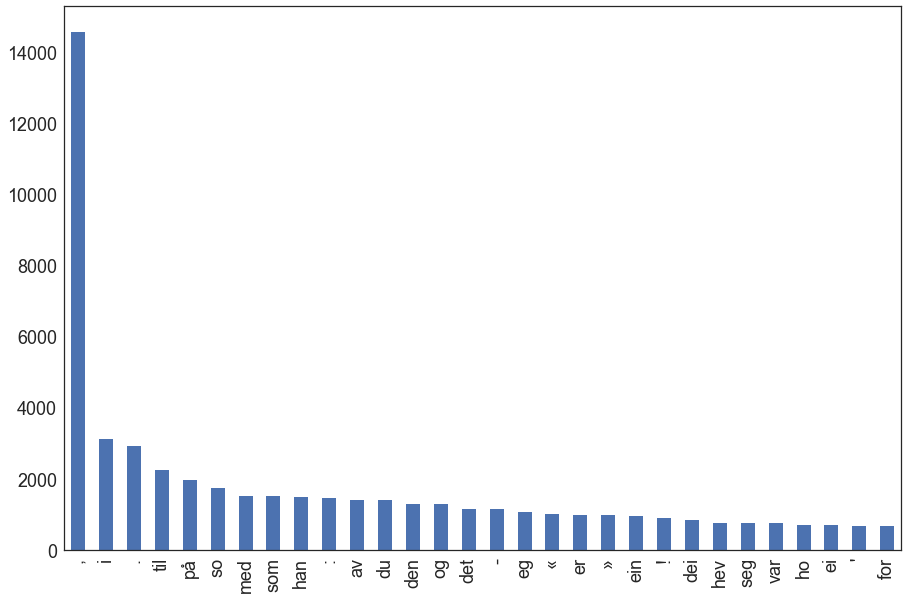

In [9]:
urnfreq.iloc[:30].plot(kind='bar', figsize=(15,10), legend=False, fontsize=18);

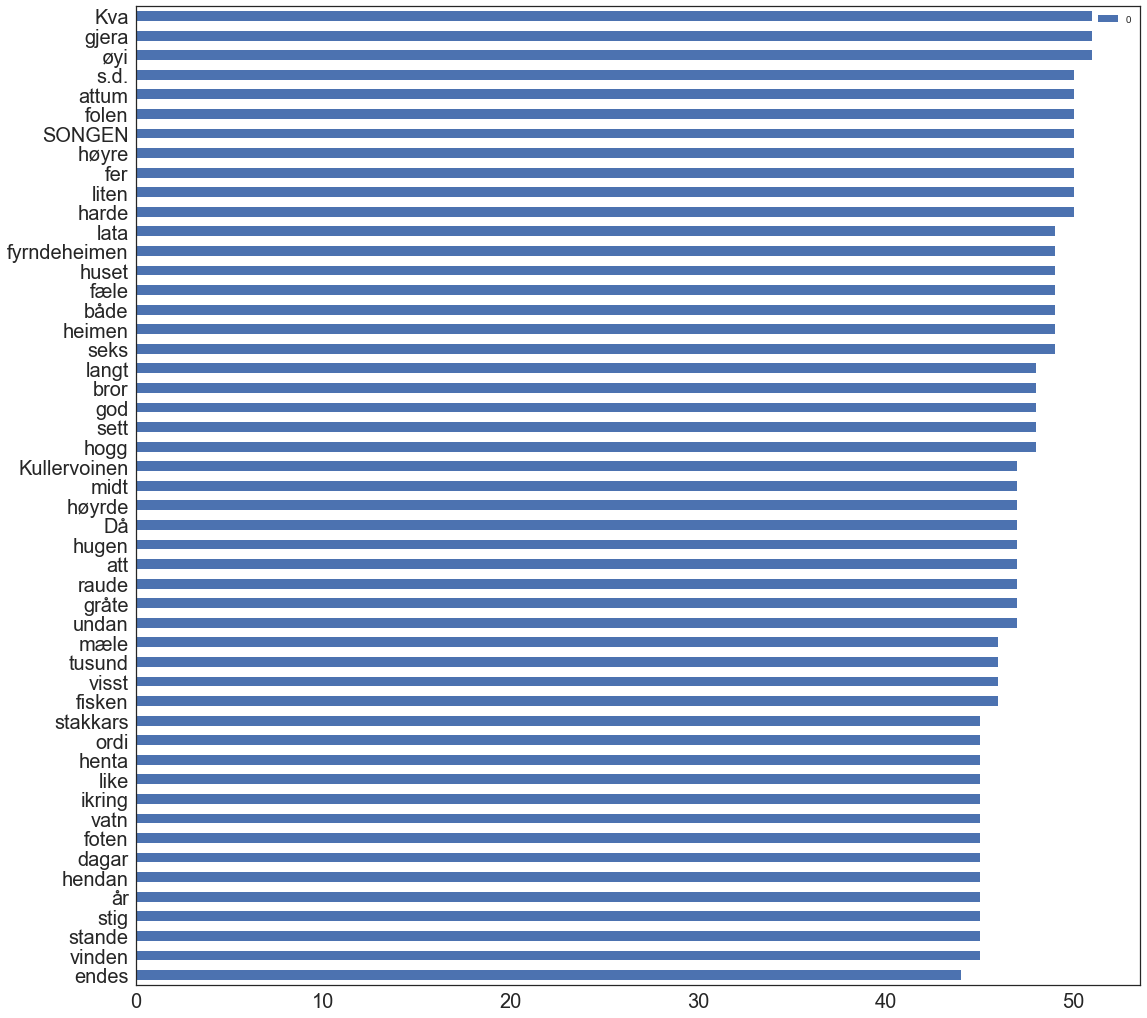

In [13]:
urnfreq.iloc[300:350].sort_values(by=0).plot(kind='barh',figsize=(18,18), fontsize=20)

## URN-sets for comparison

In [16]:
h_urn = get_urns({'author':'Hamsun%knut%', 'year':1955})
u1980 = get_urns({'year':1980})
u1920 = get_urns({'year':1920})

In [63]:
rand_urns = [x[0] for x in u1980[:60]]
hamsun_urns = [x[0] for x in u1920[:5]]
old_urns = [x[0] for x in u1920[2:38]]

In [64]:
old_urns

[2006081800021,
 2006081800055,
 2006082400044,
 2006082400045,
 2006082900001,
 2006083100021,
 2006101000016,
 2006120401001,
 2006120401002,
 2006120401011,
 2006120401039,
 2006120401040,
 2006120401042,
 2006120401046,
 2006120401050,
 2006120401053,
 2006120401067,
 2006120401068,
 2006120401098,
 2006120401107,
 2006120401114,
 2006120401115,
 2006120500023,
 2006120500045,
 2006120500053,
 2006120500064,
 2006120500066,
 2006120500075,
 2006120501064,
 2006120501073,
 2006120501090,
 2006120501091,
 2006120501092,
 2006120501115,
 2006120501116,
 2006120501117]

### Define a collection of marker words

These words may function as markers of identity, and serve as a comparison

In [67]:
embed_words = ['arbeid', 
               'arbeidet', 'arbeide',
               'land','landet','hjem','hjemme','hjemlandet',
               'rejse', 'reise','sjøen','hav','havet',
               'jorda','åkeren', 
               'gårdbruker','Gaardbruger',
               'slite', 'streve', 
               'familie','familien','kone','bror','broren','søster',
               'venn', 'venner','kamerat','kameraten','venninne','venninnen',
               'amerikanerne','amerikanere','landsmenn', 'landsmand','landsmann','engelsk', 'engelskmann',
               'indianer','indianere',
              'fattige','rike','fattigdom','rikdom','rigdom', 'Rige','rige','Fattige', 'Rigdom']
hi_words = ['og','.','i',]
words = embed_words + hi_words

### Get data for the words 

Each word is extracted from each urnset. The function

In [68]:
amerika_brev_urn = get_words_from_urnset(words, amerika_urns)

In [69]:
amerika_urn2 = get_words_from_urnset(words, amerika_urns2)

In [70]:
hamsun_urn = get_words_from_urnset(words, hamsun_urns)

In [71]:
rand_urn = get_words_from_urnset(words, rand_urns)

In [72]:
old_urn = get_words_from_urnset(words, old_urns)

## The letters

Her we look at the data from letters using a heatmap. Each URN is represented in a column, and the individual words from the marker set is coloured according to its frequency within a column.

In [39]:
heatmap(
pd.DataFrame(amerika_brev_urn).loc[embed_words]
)

## The data can be summarized over rows:

In [40]:
heatmap(pd.DataFrame(pd.DataFrame(amerika_brev_urn).loc[embed_words].sum(axis=1)))

### Repeat the process for the other urn_sets

In [41]:
heatmap(
pd.DataFrame(
    hamsun_urn  # <=== fill in urnset here
).loc[embed_words]
)

### Compare the URN-sets with each other

In the comparison all the urnsets are aggregated to one column.

In [73]:
result = pd.DataFrame(
    pd.concat([
    pd.DataFrame(amerika_brev_urn).loc[embed_words].sum(axis = 1),
    pd.DataFrame(amerika_urn2).loc[embed_words].sum(axis = 1),
    pd.DataFrame(hamsun_urn).loc[embed_words].sum(axis = 1),
    pd.DataFrame(rand_urn).loc[embed_words].sum(axis = 1),
    pd.DataFrame(old_urn).loc[embed_words].sum(axis = 1)
    ],
    axis=1
))

# column names for easy interpretation

result.columns = 'A-Brev Amerika Hamsun Rand Old'.split()
heatmap(result)

## Comparing by way of division

In [25]:
import numpy as np
comparo = pd.DataFrame(
    pd.DataFrame(
        amerika_brev_urn).loc[embed_words].sum(axis=1)/pd.DataFrame(
        hamsun_urn).loc[embed_words].sum(axis=1))
comparo=comparo.replace([np.inf, -np.inf], np.nan).dropna()
comparo.describe()

,0
count,24.000000
mean,54.199168
std,69.150168
min,0.250000
25%,10.000000
50%,18.012500
75%,93.925000
max,295.000000
